### Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.metrics import silhouette_score
from scipy.stats import probplot
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, SpectralClustering
from sklearn.neighbors import NearestNeighbors
from kneed import KneeLocator
from clusteval import clusteval
from sklearn.decomposition import PCA
from datetime import date

### Loading Dataset

In [2]:
data=pd.read_csv(r"D:\bank_transactions.csv")

### Data Preprocessing

In [3]:
data.shape

(1048567, 9)

In [4]:
## Checking for na values ####
print(data.isna().sum())

TransactionID                 0
CustomerID                    0
CustomerDOB                3397
CustGender                 1100
CustLocation                151
CustAccountBalance         2369
TransactionDate               0
TransactionTime               0
TransactionAmount (INR)       0
dtype: int64


In [5]:
plt.rcParams['figure.figsize'] = (12,8)
pd.set_option('display.float_format',lambda x: '%.2f' % x)

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048567 entries, 0 to 1048566
Data columns (total 9 columns):
 #   Column                   Non-Null Count    Dtype  
---  ------                   --------------    -----  
 0   TransactionID            1048567 non-null  object 
 1   CustomerID               1048567 non-null  object 
 2   CustomerDOB              1045170 non-null  object 
 3   CustGender               1047467 non-null  object 
 4   CustLocation             1048416 non-null  object 
 5   CustAccountBalance       1046198 non-null  float64
 6   TransactionDate          1048567 non-null  object 
 7   TransactionTime          1048567 non-null  int64  
 8   TransactionAmount (INR)  1048567 non-null  float64
dtypes: float64(2), int64(1), object(6)
memory usage: 72.0+ MB


In [7]:
### Checking for attribute mean,median ,Q1,Q3,IQR ##
data.describe()

,CustAccountBalance,TransactionTime,TransactionAmount (INR)
count,1046198.00,1048567.00,1048567.00
mean,115403.54,157087.53,1574.34
std,846485.38,51261.85,6574.74
min,0.00,0.00,0.00
25%,4721.76,124030.00,161.00
50%,16792.18,164226.00,459.03
75%,57657.36,200010.00,1200.00
max,115035495.10,235959.00,1560034.99


In [8]:
data.duplicated().sum()

0

### Data Features exploration

#### Droping TransactionID and CustomerID from Dataset

In [9]:
data=data.drop(['TransactionID','CustomerID'],axis=1)

In [10]:
data.head()

,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR)
0,10/1/94,F,JAMSHEDPUR,17819.05,2/8/16,143207,25.00
1,4/4/57,M,JHAJJAR,2270.69,2/8/16,141858,27999.00
2,26/11/96,F,MUMBAI,17874.44,2/8/16,142712,459.00
3,14/9/73,F,MUMBAI,866503.21,2/8/16,142714,2060.00
4,24/3/88,F,NAVI MUMBAI,6714.43,2/8/16,181156,1762.50


In [11]:
data['CustGender'].value_counts()

M    765530
F    281936
T         1
Name: CustGender, dtype: int64

In [12]:
data.drop(data[data['CustGender'].isin(['T'])].index,axis=0,inplace=True)
data['CustGender'].unique()

array(['F', 'M', nan], dtype=object)

In [13]:
data = data[~data['CustomerDOB'].isna()]
data.CustomerDOB = pd.to_datetime(data.CustomerDOB,errors='coerce')

#### Converting Customers Date of Births in their Age

In [14]:
def Age(birthdate):
    today = date.today()
    Age = today.year - birthdate.year - ((today.month, today.day) < (birthdate.month, birthdate.day))
    return Age

In [15]:
data['Age'] = data.CustomerDOB.apply(Age)

In [16]:
data = data[data['Age']>0]
data.drop('CustomerDOB',axis=1,inplace=True)
data.shape

(970106, 7)

### Treating na values

In [17]:
for col in data.columns:
    print("Percentage of null values of {}:".format(col),str(np.round(data[col].isna().sum()/len(data)*100,2)) + '%')

Percentage of null values of CustGender: 0.09%
Percentage of null values of CustLocation: 0.02%
Percentage of null values of CustAccountBalance: 0.23%
Percentage of null values of TransactionDate: 0.0%
Percentage of null values of TransactionTime: 0.0%
Percentage of null values of TransactionAmount (INR): 0.0%
Percentage of null values of Age: 0.0%


In [18]:
for col in data.columns:
    print("Percentage of unique values of {}:".format(col),str(np.round(data[col].nunique()/len(data)*100,2)) + '%')

Percentage of unique values of CustGender: 0.0%
Percentage of unique values of CustLocation: 0.91%
Percentage of unique values of CustAccountBalance: 15.07%
Percentage of unique values of TransactionDate: 0.01%
Percentage of unique values of TransactionTime: 8.39%
Percentage of unique values of TransactionAmount (INR): 8.72%
Percentage of unique values of Age: 0.01%


In [19]:
data=data[~data['CustGender'].isna()]

In [20]:
data = data[~data['CustLocation'].isna()]

In [21]:
data.CustAccountBalance = data.CustAccountBalance.fillna(data.
                                                         groupby('CustLocation')['CustAccountBalance'].transform('mean'))

In [22]:
data = data[~data.CustAccountBalance.isna()]

In [23]:
data.isna().sum()

CustGender                 0
CustLocation               0
CustAccountBalance         0
TransactionDate            0
TransactionTime            0
TransactionAmount (INR)    0
Age                        0
dtype: int64

In [24]:
data.shape

(968909, 7)

In [25]:
data.TransactionDate = pd.to_datetime(data.TransactionDate,errors='coerce')

In [26]:
data['TransactionMonth'] = data.TransactionDate.dt.month
data['TransactionMonthName'] = data.TransactionDate.dt.month_name()
data['TransactionDay'] = data.TransactionDate.dt.day
data['TransactionDayName'] = data.TransactionDate.dt.day_name()

In [27]:
data.drop('TransactionDate',axis=1,inplace=True)

### Exploratory Data Analysis (EDA) of Preprocessed Dataset

Skewness of CustAccountBalance: 36.61795538324552
Kurtosis of CustAccountBalance: 2650.4742083374363
Distribution Plot of CustAccountBalance:


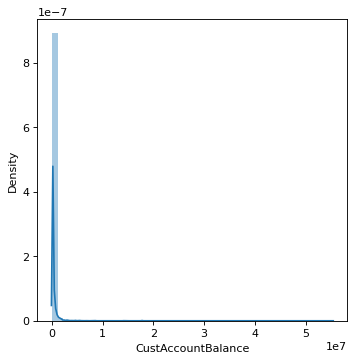

Box Plot of CustAccountBalance:


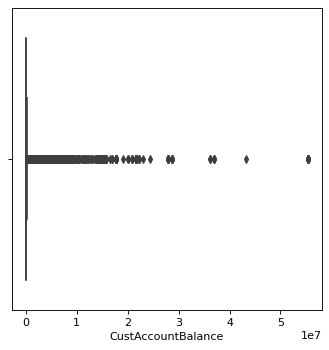

Quantile-Quantile Plot of CustAccountBalance:


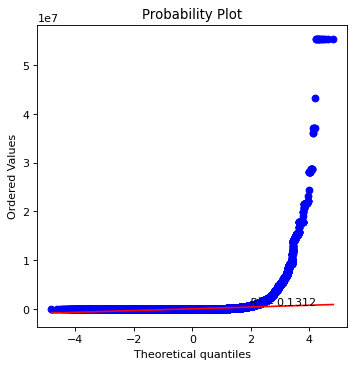

Skewness of TransactionAmount (INR): 54.35309885783315
Kurtosis of TransactionAmount (INR): 8863.538556781345
Distribution Plot of TransactionAmount (INR):


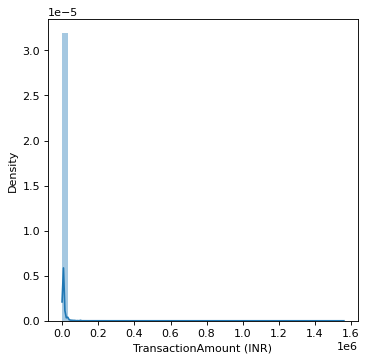

Box Plot of TransactionAmount (INR):


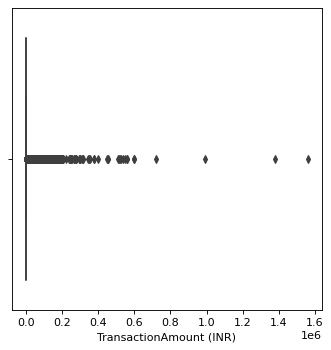

Quantile-Quantile Plot of TransactionAmount (INR):


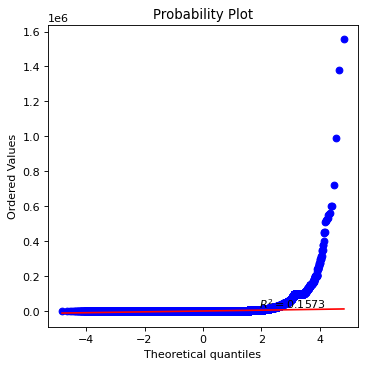

In [28]:
for col in data.columns:
    if data[col].dtypes == np.float64:
        print("Skewness of {}:".format(col),data[col].skew())
        print("Kurtosis of {}:".format(col),data[col].kurt())
        plt.figure(figsize=(5,5),dpi=80)
        print("Distribution Plot of {}:".format(col))
        sns.distplot(data[col])
        plt.show()
        print("Box Plot of {}:".format(col))
        plt.figure(figsize=(5,5),dpi=80)
        sns.boxplot(data[col])
        plt.show()
        print("Quantile-Quantile Plot of {}:".format(col))
        plt.figure(figsize=(5,5),dpi=80)
        probplot(data[col],plot=plt,rvalue=True)
        plt.show()

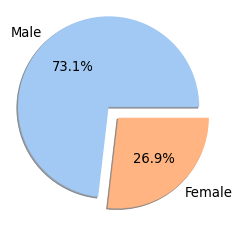

In [31]:
labels = ["Male","Female"]
values = data.CustGender.value_counts().values
col=sns.color_palette("pastel")
explode = (0.16,0)
plt.figure(figsize=(6,6),dpi=50)
plt.pie(values,labels=labels,explode=explode,shadow=1,
        autopct='%1.1f%%',colors=col,textprops={'fontsize': 19,"color":'Black'});

##### A significant proportion of bank customers are males accounting for about 73% of the total share

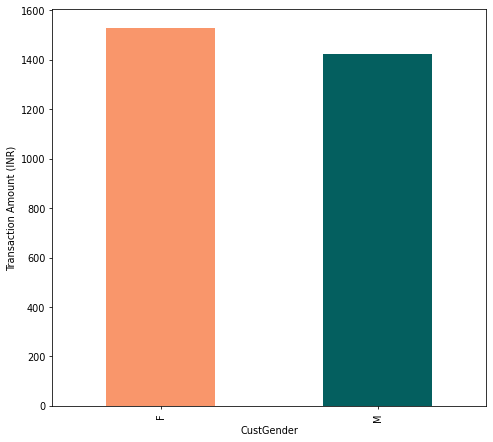

In [34]:
plt.figure(figsize=(8,7.5),dpi=70)
ax = data.groupby('CustGender')['TransactionAmount (INR)'].mean().plot(kind='bar',
                                                                       color=('#F9966B','#045F5F'))
plt.ylabel('Transaction Amount (INR)');

###### At an average, females make slightly higher transactions than males.

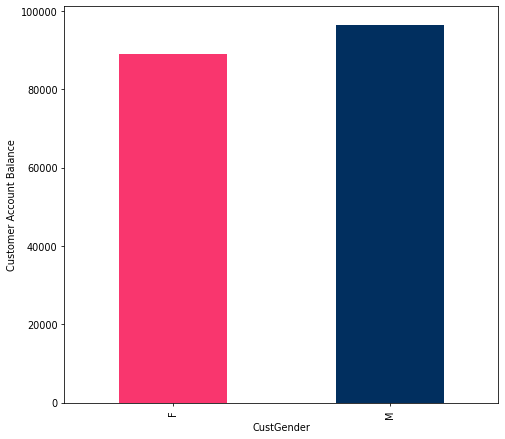

In [35]:
plt.figure(figsize=(8,7.5),dpi=70)
ax = data.groupby('CustGender')['CustAccountBalance'].mean().plot(kind='bar',
                                                                  color=['#F9366E','#012F5F'])
plt.ylabel('Customer Account Balance');

##### At an average, male customers have marginally higher account balances in comparison to their female counterparts.

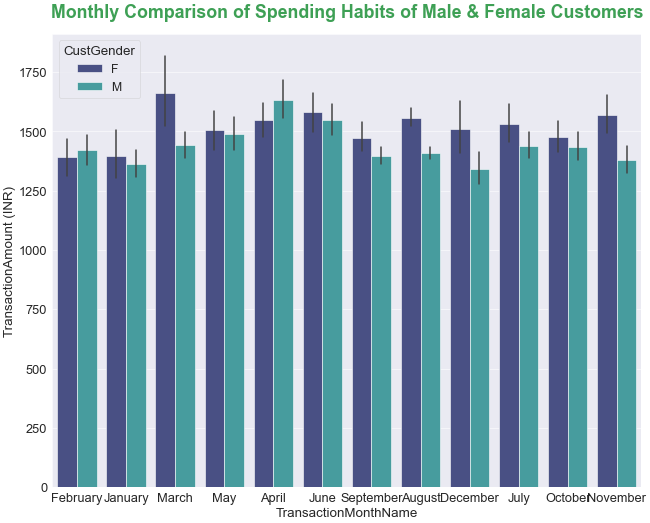

In [37]:
plt.figure(figsize=(19,15),dpi=40)
plt.rc('xtick', labelsize=23) 
plt.rc('ytick', labelsize=23)
sns.barplot(data=data,x='TransactionMonthName',y='TransactionAmount (INR)',palette="mako",hue='CustGender')

sns.set(font_scale=2)
plt.title('Monthly Comparison of Spending Habits of Male & Female Customers',fontsize=32,fontweight='bold',color='#3EA055',pad=30);

##### Male customers make higher transactions than their female counterparts only during the months of February and April. In all the remaining months, female customers perform greater transactions. Therefore, the bank must provide more special offers and incentives to female customers as they are likely to be substantially active in making larger transactions almost throughout the entire year. 
##### Higher value transactions are mostly done during the months of March, April and June.

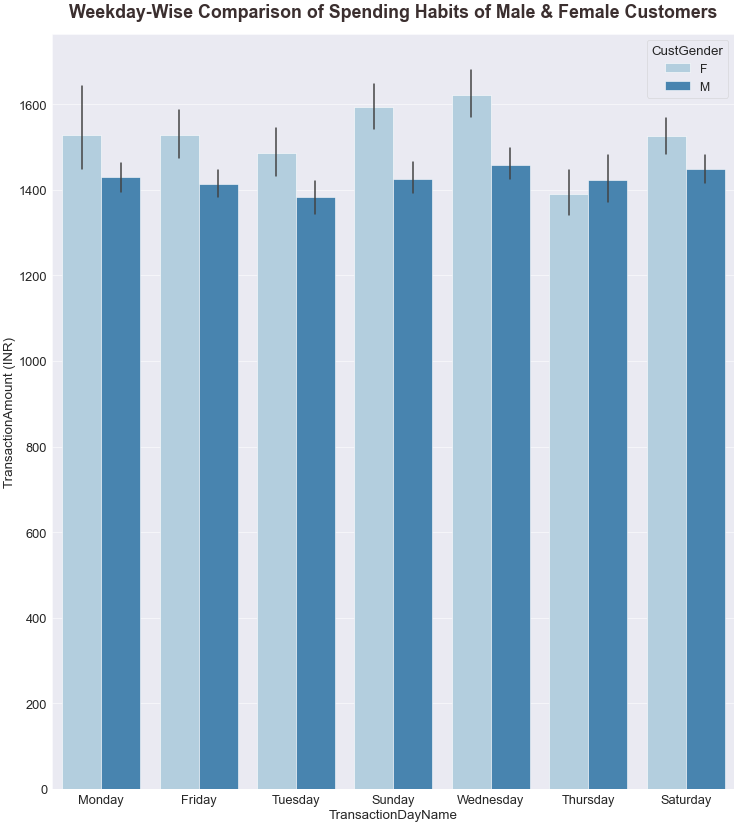

In [40]:
plt.figure(figsize=(22,25),dpi=40)
plt.rc('xtick', labelsize=23) 
plt.rc('ytick', labelsize=23)
sns.barplot(data=data,x='TransactionDayName',y='TransactionAmount (INR)',palette='Blues',hue='CustGender')
plt.title('Weekday-Wise Comparison of Spending Habits of Male & Female Customers',fontsize=32,fontweight='bold',color='#3B2F2F',pad=30);

##### Female customers perform higher transactions than their male counterparts in almost every week day.

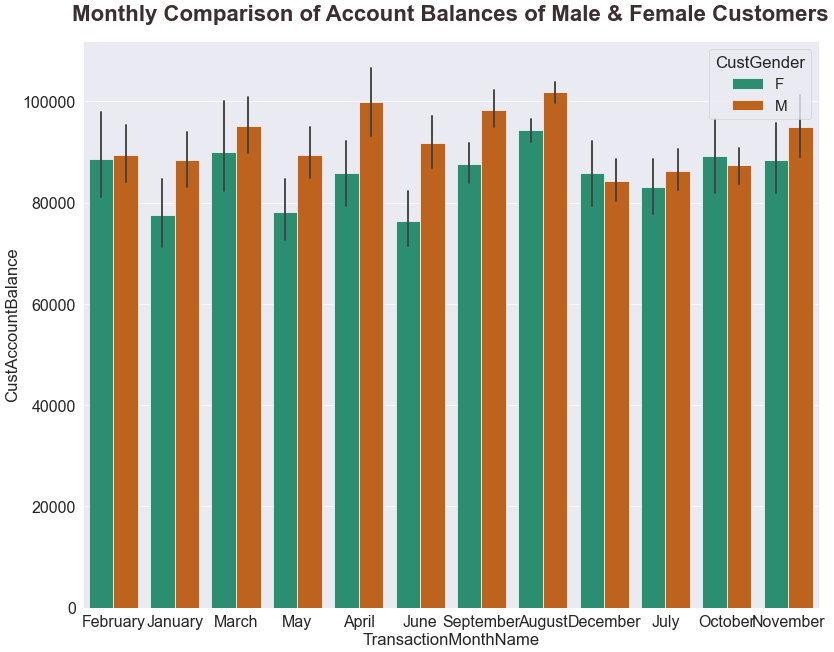

In [41]:
plt.figure(figsize=(19,15),dpi=50)
plt.rc('xtick', labelsize=23) 
plt.rc('ytick', labelsize=23)
sns.barplot(data=data,x='TransactionMonthName',y='CustAccountBalance',palette='Dark2',hue='CustGender')
plt.title('Monthly Comparison of Account Balances of Male & Female Customers',fontsize=32,fontweight='bold',color='#3B2F2F',pad=30);

##### Male customers predominantly have greater account balances as compared to their female counterparts. This is evident from the fact that they generally make comparatively low value transactions than female customers.

<AxesSubplot:xlabel='TransactionMonthName', ylabel='TransactionAmount (INR)'>

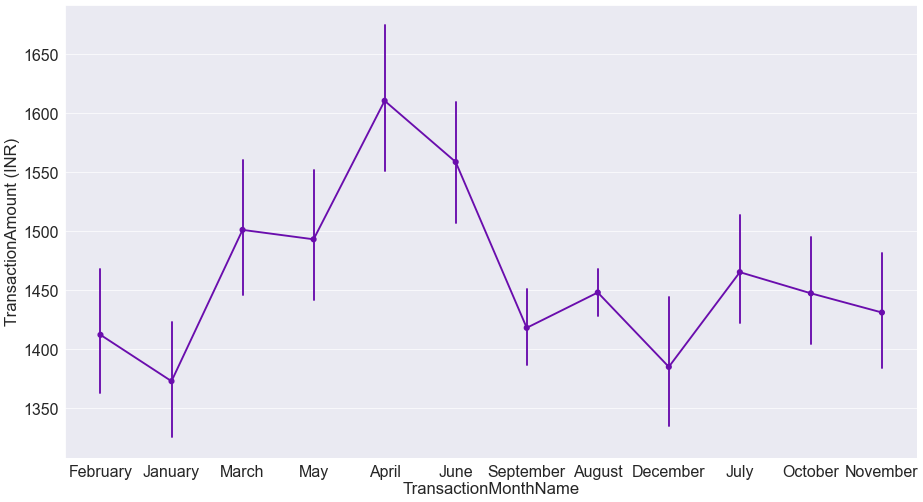

In [45]:
plt.figure(figsize=(22,12),dpi=50)
sns.pointplot(data=data,x='TransactionMonthName',y='TransactionAmount (INR)',color='#6A0DAD',)

##### Highest value transactions are performed during the summer months while least value transactions are made in the winter months.

<AxesSubplot:xlabel='TransactionMonthName', ylabel='CustAccountBalance'>

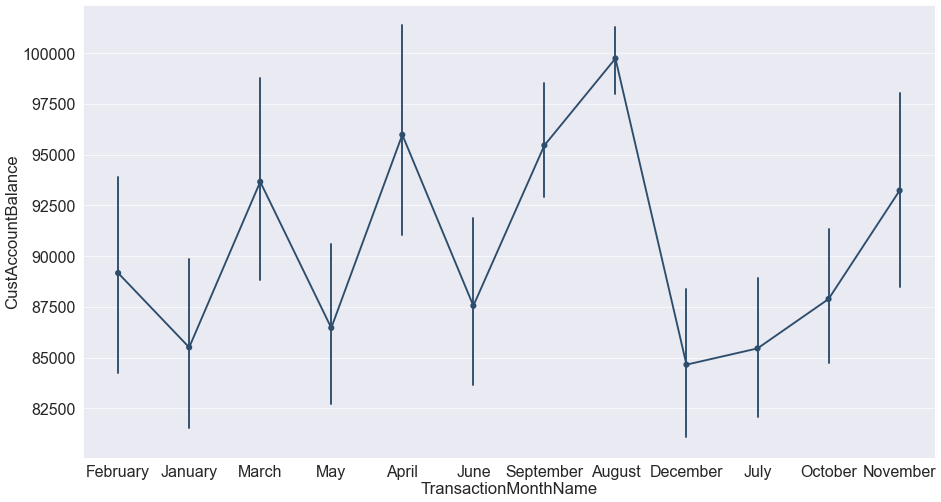

In [46]:
plt.figure(figsize=(22,12),dpi=50)
sns.pointplot(data=data,x='TransactionMonthName',y='CustAccountBalance',color='#2D4D6C')

##### Commonly, the account balances of customers are highest in the months of August and September whereas they are lowest in the months of July and December. In the festive months, the customer account balances drop significantly which makes sense as people usually expend more money during the festive season.

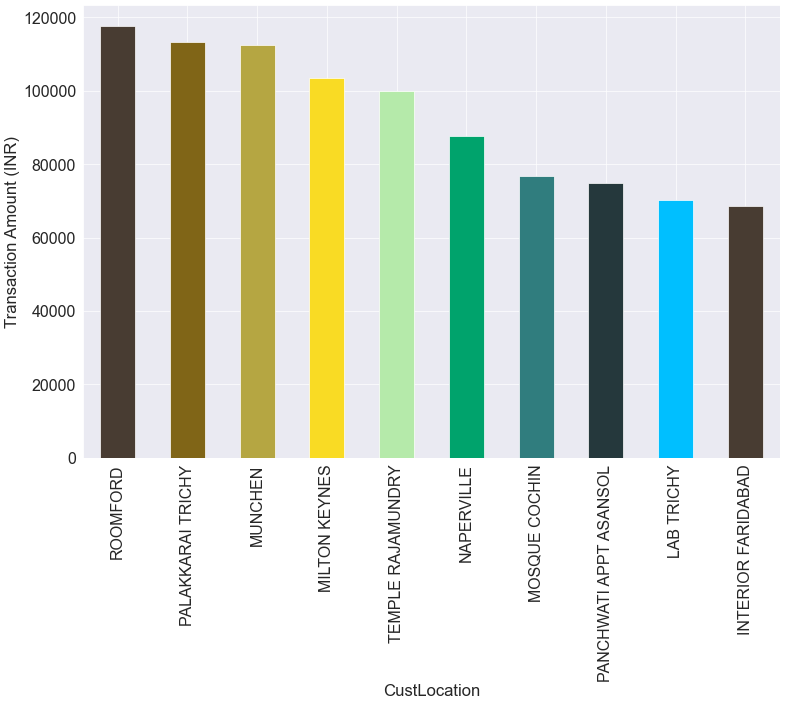

In [47]:
plt.figure(figsize=(18,12),dpi=50)
data.groupby('CustLocation')['TransactionAmount (INR)'].mean().sort_values(ascending=False)[:10].plot(kind='bar',
                                                                                                      color=["#483C32","#806517","#B5A642","#F9DB24","#B5EAAA","#00A36C","#307D7E","#25383C","#00BFFF"])
plt.ylabel('Transaction Amount (INR)');

##### Customers belonging to the Roomford bank branch in United Kingdom mostly perform the highest transactions which are closely followed by the bank branches in Palakkarai Trichy(Tamil Nadu, India) and Munchen in Germany.

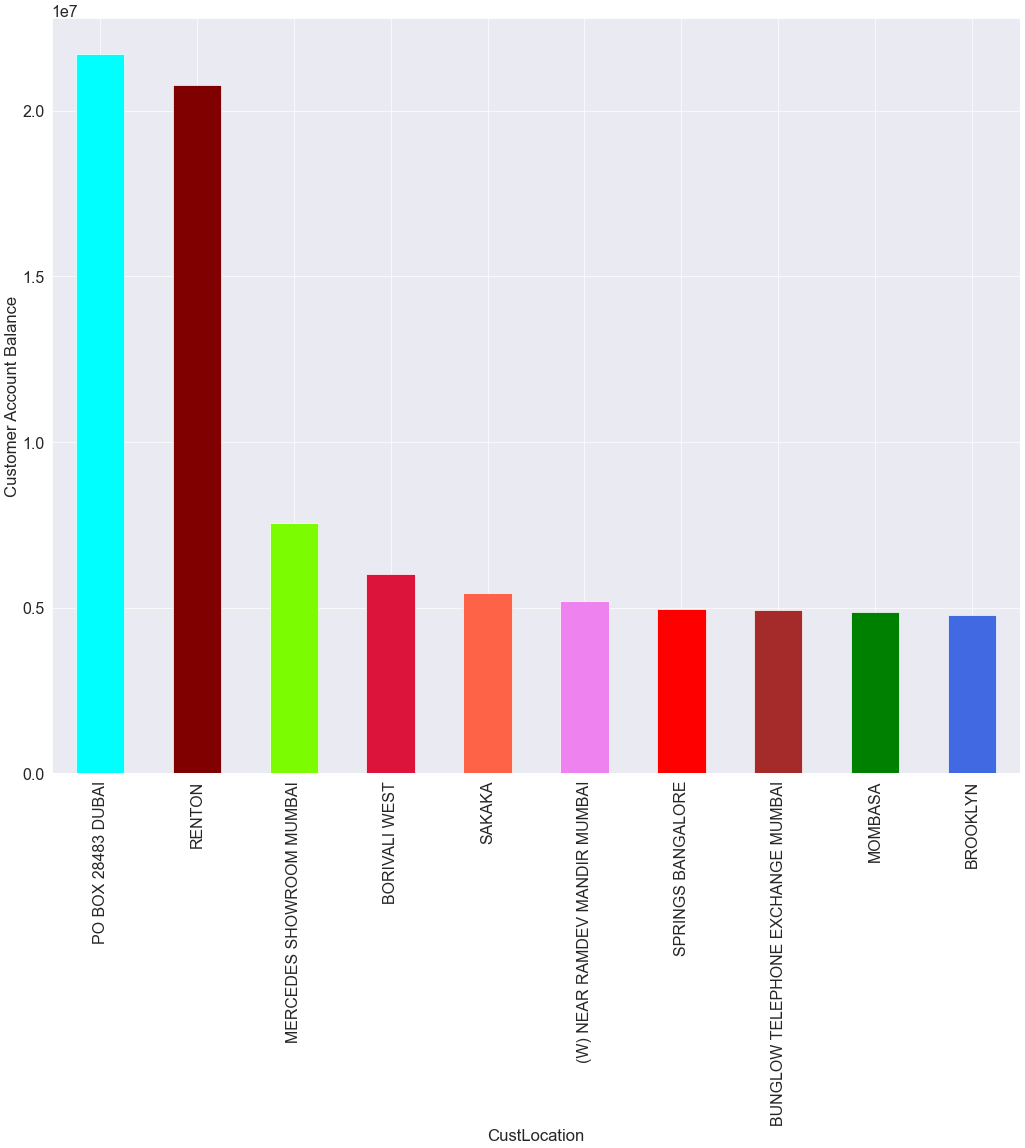

In [48]:
plt.figure(figsize=(25,20),dpi=50)
data.groupby('CustLocation')['CustAccountBalance'].mean().sort_values(ascending=False)[:10].plot(kind='bar',color=['aqua','maroon','lawngreen','crimson','tomato','violet','red','brown','green','royalblue'])
plt.ylabel('Customer Account Balance');


##### Customers living in PO Box 28483 Dubai bank branch have the highest account balances among all customers.

<AxesSubplot:xlabel='Age', ylabel='CustAccountBalance'>

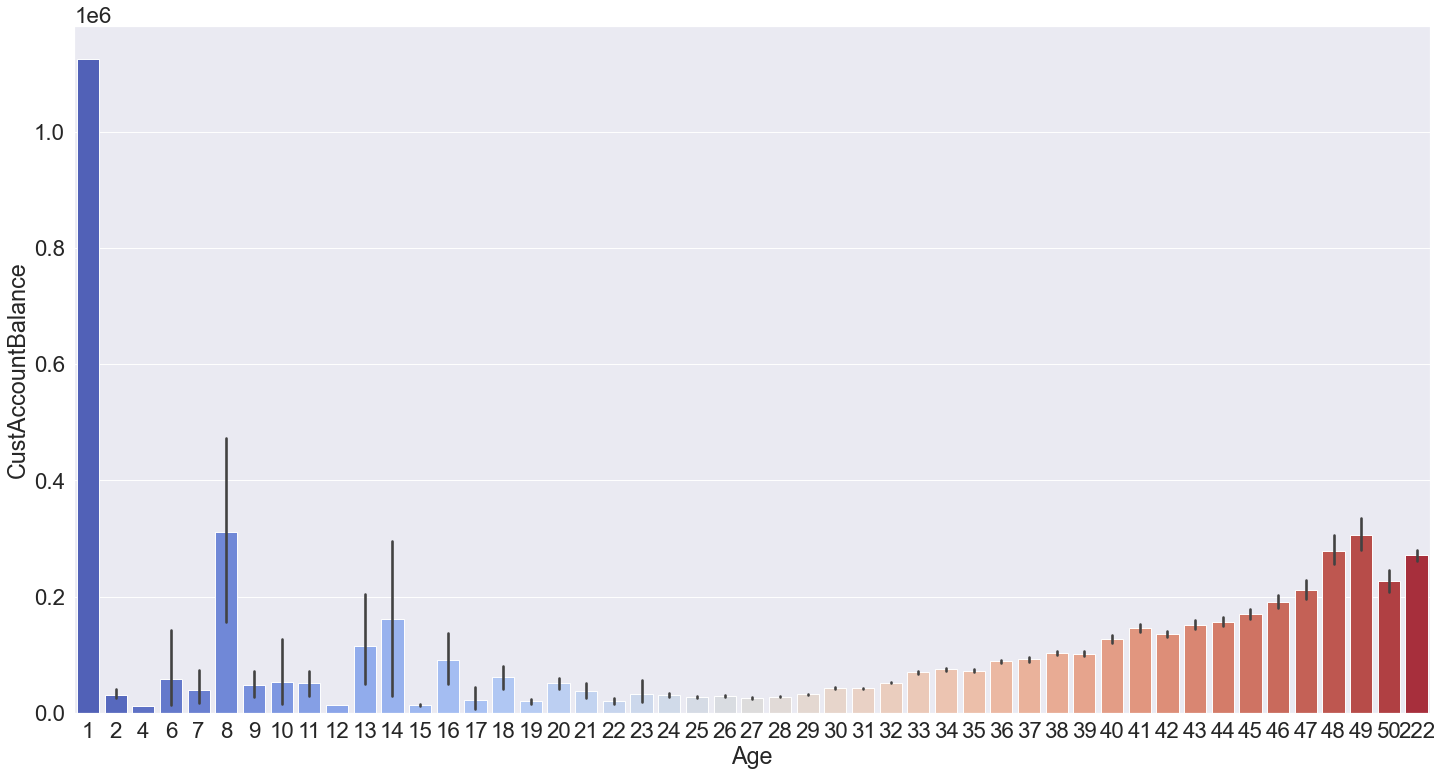

In [49]:
plt.figure(figsize=(25,13),dpi=70)
sns.barplot(data=data,x='Age',y='CustAccountBalance',palette='coolwarm')

##### In general, the account balances of customers rise abruptly with increase in their ages, attaining a peak by the old age of 50 years or more, although there are a few excepions to this matter. The account balances of younger adults in the age range of 19 to 22 years have higher account balances in comparison to their surrounding age groups.

<AxesSubplot:xlabel='Age', ylabel='TransactionAmount (INR)'>

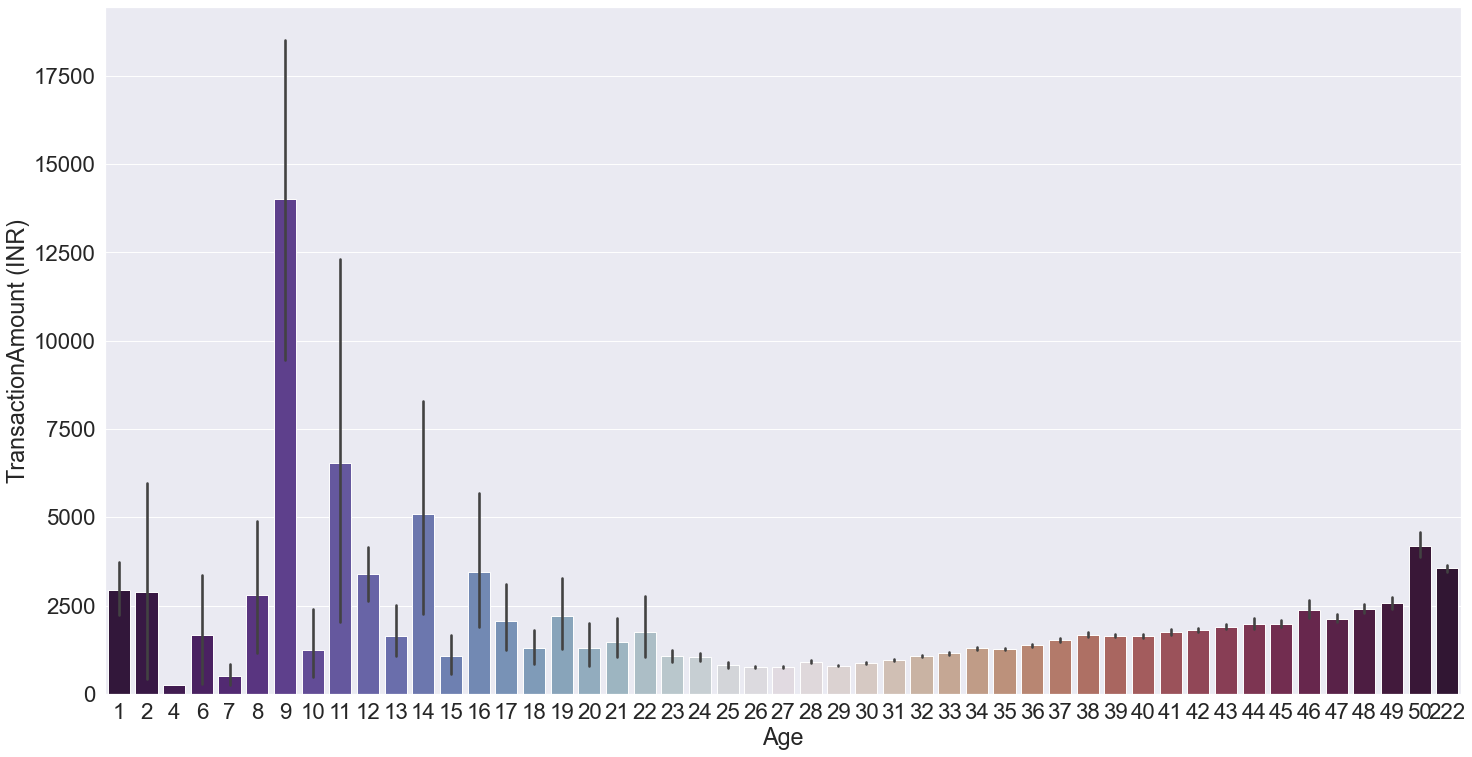

In [50]:
plt.figure(figsize=(25,13),dpi=70)
sns.barplot(data=data,x='Age',y='TransactionAmount (INR)',palette='twilight_shifted')

##### Likewise, an exactly similar trend prevails in case of transaction amounts as well. Younger adult customers, in the age range of 19 to 24 years, perform exorbitant transactions as compared to their surrounding age groups. This is most probably due to the reason that younger adults between the ages of 18 to 24 years have their own career aspirations to fulfil as a consequence of which they generally have lavish and extravagant demands for fulfilling their passions and interests and for facilitating their development through all means. Nevertheless, middle age senior adults and elderly customers make comparatively more extortionate transactions for managing their families and livelihoods

(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5]),
 [Text(0.5, 0, 'CustAccountBalance'),
  Text(1.5, 0, 'TransactionTime'),
  Text(2.5, 0, 'TransactionAmount (INR)'),
  Text(3.5, 0, 'Age'),
  Text(4.5, 0, 'TransactionMonth'),
  Text(5.5, 0, 'TransactionDay')])

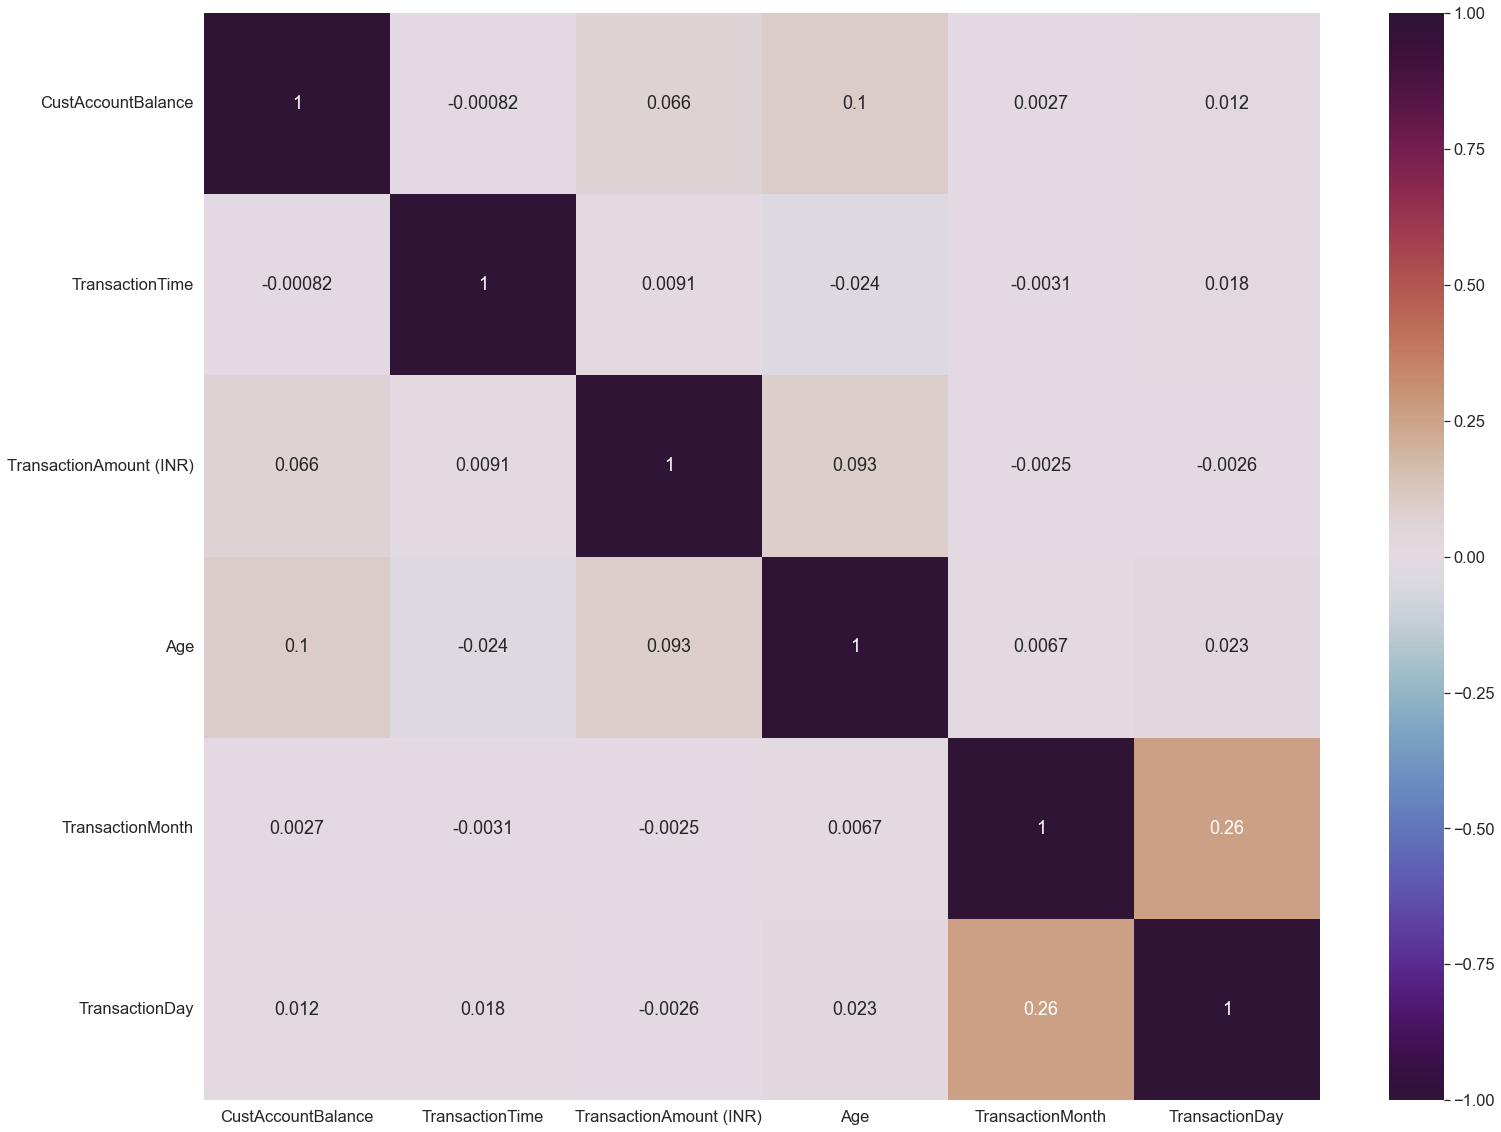

In [66]:
plt.figure(figsize=(25,20))
sns.heatmap(data.corr(),annot=True,cmap='twilight_shifted',vmin=-1,vmax=1)
sns.set(font_scale=1.5)
plt.yticks(rotation=0)
plt.xticks(rotation=0)

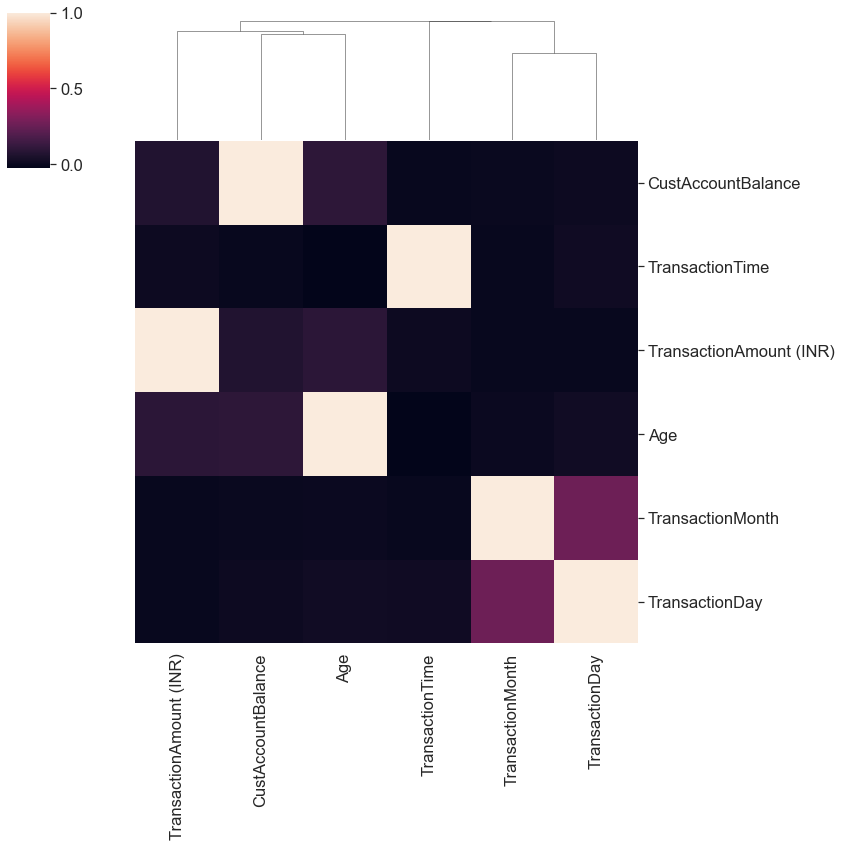

In [67]:
sns.clustermap(data.corr(),figsize=(12,12),row_cluster=False)

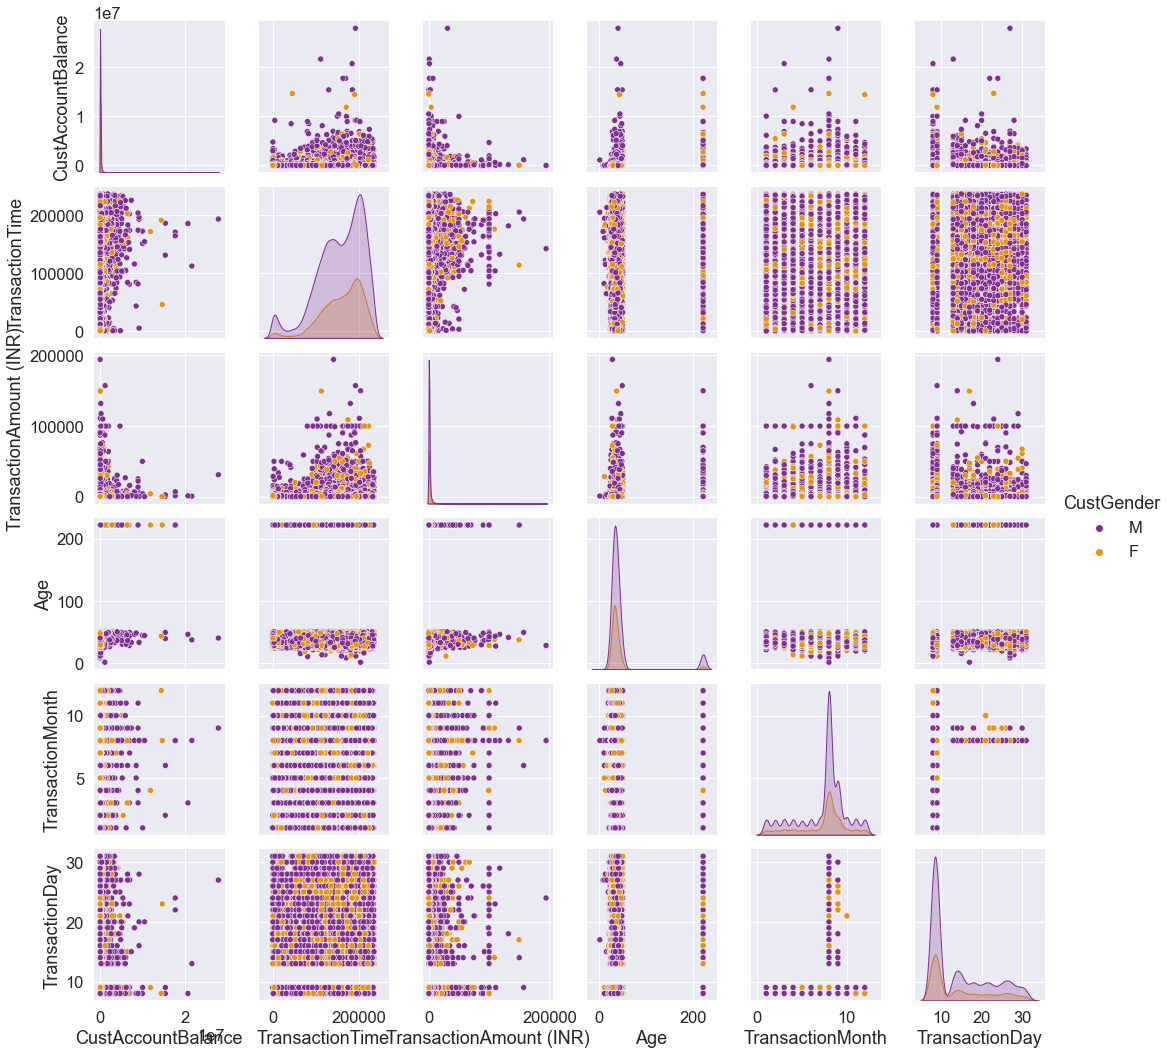

In [68]:
sns.pairplot(data.sample(n=50000),hue="CustGender",palette='CMRmap')

In [69]:
data.CustGender.replace(['F','M'],[0,1],inplace=True)
data.CustGender = data.CustGender.astype(np.int64)

### Categorical Encoding

In [70]:
encoder = LabelEncoder()
data.CustLocation = encoder.fit_transform(data.CustLocation)
data.CustLocation = data.CustLocation.astype(np.int64)

In [71]:
data.drop(['TransactionMonthName','TransactionDayName'],axis=1,inplace=True)

### Feature Scaling

In [72]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data)
scaled_data = pd.DataFrame(scaled_data,columns=data.columns)
scaled_data.head()

,CustGender,CustLocation,CustAccountBalance,TransactionTime,TransactionAmount (INR),Age,TransactionMonth,TransactionDay
0,-1.65,-0.23,-0.15,-0.27,-0.23,-0.42,-2.03,-0.88
1,-1.65,0.48,-0.15,-0.28,-0.16,-0.47,-2.03,-0.88
2,-1.65,0.48,1.55,-0.28,0.10,0.05,-2.03,-0.88
3,-1.65,0.64,-0.18,0.46,0.05,-0.27,-2.03,-0.88
4,-1.65,-0.26,-0.08,0.32,-0.13,0.10,-2.03,-0.88


## Unsupervised Machine Learning

In [73]:
temp = scaled_data.sample(n=100000)

### K Means Clustering

In [74]:
base_kmeans = KMeans(random_state=141)
base_kmeans.fit(temp)

KMeans(random_state=141)

In [75]:
labels = set(base_kmeans.labels_)
labels

{0, 1, 2, 3, 4, 5, 6, 7}

In [76]:
print("Silhouette Score:",str(np.round(silhouette_score(temp,base_kmeans.labels_)*100,2)) + '%')

Silhouette Score: 22.03%


In [77]:
for i in range(1,11):
    for init in ['k-means++','random']:
        for algo in ['auto','full','elkan']:
            kmeans = KMeans(n_clusters=i,init=init,algorithm=algo,random_state=101)
            kmeans.fit(temp)
            print("Number of Clusters: {}".format(i))
            print("Initialization Algorithm: {}".format(init))
            print("Algorithm: {}".format(algo))
            print("Sum of Squared Distance: %d" % kmeans.inertia_)
            print('-----------------')

Number of Clusters: 1
Initialization Algorithm: k-means++
Algorithm: auto
Sum of Squared Distance: 820371
-----------------
Number of Clusters: 1
Initialization Algorithm: k-means++
Algorithm: full
Sum of Squared Distance: 820371
-----------------
Number of Clusters: 1
Initialization Algorithm: k-means++
Algorithm: elkan
Sum of Squared Distance: 820371
-----------------
Number of Clusters: 1
Initialization Algorithm: random
Algorithm: auto
Sum of Squared Distance: 820371
-----------------
Number of Clusters: 1
Initialization Algorithm: random
Algorithm: full
Sum of Squared Distance: 820371
-----------------
Number of Clusters: 1
Initialization Algorithm: random
Algorithm: elkan
Sum of Squared Distance: 820371
-----------------
Number of Clusters: 2
Initialization Algorithm: k-means++
Algorithm: auto
Sum of Squared Distance: 719451
-----------------
Number of Clusters: 2
Initialization Algorithm: k-means++
Algorithm: full
Sum of Squared Distance: 719451
-----------------
Number of Clust

In [78]:
optimized_kmeans = KMeans(n_clusters=10,init='k-means++',algorithm='elkan',random_state=141)
optimized_kmeans.fit(temp)
print("Silhouette Score:",str(np.round(silhouette_score(temp,optimized_kmeans.labels_)*100,2)) + '%')

Silhouette Score: 21.73%


In [79]:
print("Estimated number of clusters:", len(set(optimized_kmeans.labels_)), set(optimized_kmeans.labels_))
print("Estimated number of noise points:", list(optimized_kmeans.labels_).count(-1))

Estimated number of clusters: 10 {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
Estimated number of noise points: 0


<AxesSubplot:xlabel='CustAccountBalance', ylabel='TransactionAmount (INR)'>

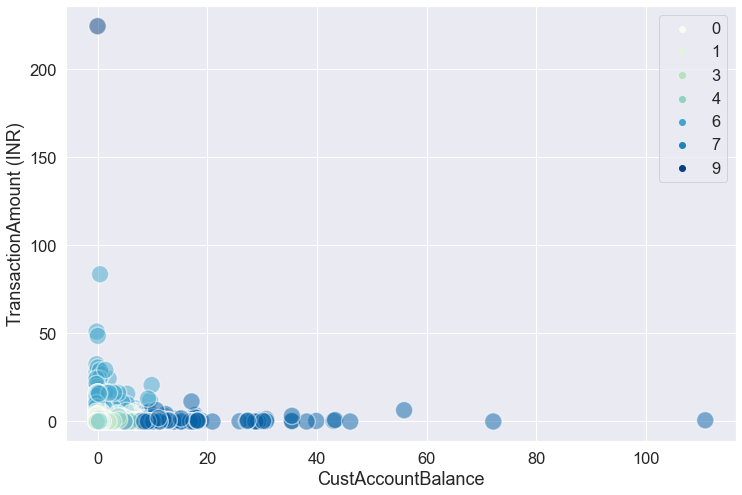

In [80]:
sns.scatterplot(data=temp,x='CustAccountBalance',y='TransactionAmount (INR)',hue=optimized_kmeans.labels_,s=300,alpha=0.5,palette='GnBu')

In [81]:
ce = clusteval(cluster='kmeans',savemem=True,verbose=4)
results = ce.fit(np.reshape(np.ravel(temp.sample(5000)),(-1,1)))
cluster_labels = results['labx']


[clusteval] >Fit using kmeans with metric: euclidean, and linkage: ward
[clusteval] >Evaluate using silhouette.
[clusteval] >Save memory enabled for kmeans with evaluation silhouette.


100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [06:22<00:00, 16.61s/it]

[clusteval] >Optimal number clusters detected: [10].
[clusteval] >Fin.


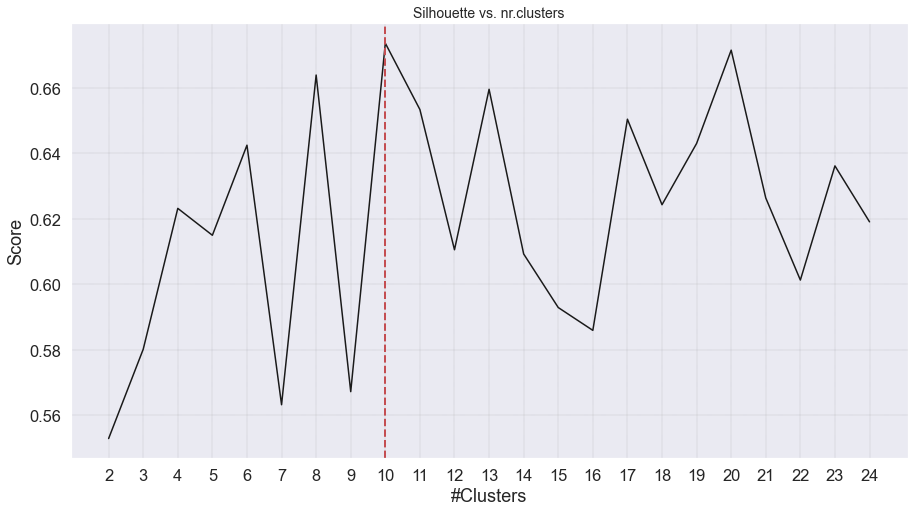

(<Figure size 1080x576 with 1 Axes>,
 <AxesSubplot:title={'center':'Silhouette vs. nr.clusters'}, xlabel='#Clusters', ylabel='Score'>)

In [82]:
ce.plot()

#### Hierarchical Clustering

In [83]:
mmscaler = MinMaxScaler()
minmax_scaled_data = mmscaler.fit_transform(data)
minmax_scaled_data = pd.DataFrame(minmax_scaled_data,columns=data.columns)
minmax_scaled_data.head()

,CustGender,CustLocation,CustAccountBalance,TransactionTime,TransactionAmount (INR),Age,TransactionMonth,TransactionDay
0,0.00,0.38,0.00,0.61,0.00,0.12,0.09,0.00
1,0.00,0.56,0.00,0.60,0.00,0.11,0.09,0.00
2,0.00,0.56,0.02,0.60,0.00,0.21,0.09,0.00
3,0.00,0.60,0.00,0.77,0.00,0.15,0.09,0.00
4,0.00,0.37,0.00,0.74,0.00,0.22,0.09,0.00


In [84]:
temp2 = minmax_scaled_data.sample(n=25000)

In [85]:
base_hc = AgglomerativeClustering()
base_hc.fit(temp2)

AgglomerativeClustering()

In [86]:
print("Estimated number of clusters:", set(base_hc.labels_))

Estimated number of clusters: {0, 1}


In [87]:
print("Estimated number of noise points:", list(base_hc.labels_).count(-1))

Estimated number of noise points: 0


In [88]:
print("Silhouette Score:",str(np.round(silhouette_score(temp2,base_hc.labels_)*100,2)) + '%')

Silhouette Score: 41.85%


<AxesSubplot:xlabel='CustAccountBalance', ylabel='TransactionAmount (INR)'>

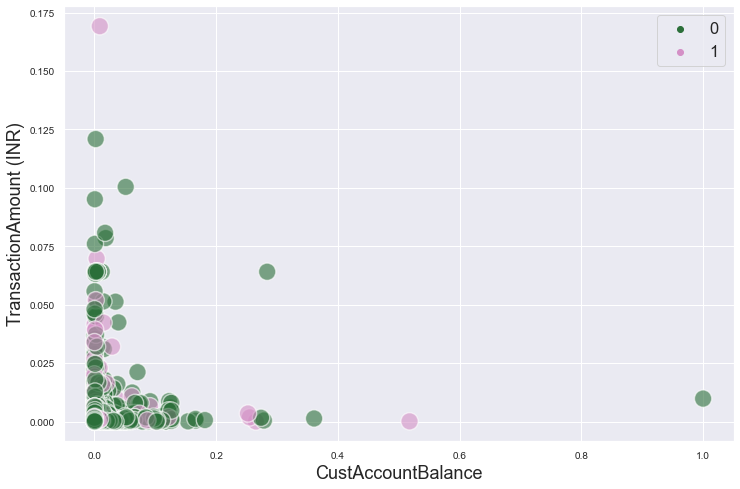

In [89]:
sns.scatterplot(temp2['CustAccountBalance'],temp2['TransactionAmount (INR)']
                ,hue=base_hc.labels_,s=300,alpha=0.6,palette='cubehelix')

In [90]:
temp2_samp = temp2.sample(500)
ce = clusteval(verbose=4)
results = ce.fit(np.reshape(np.ravel(temp2_samp),(-1,1)))
results


[clusteval] >Fit using agglomerative with metric: euclidean, and linkage: ward
[clusteval] >Evaluate using silhouette.


100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:03<00:00,  6.05it/s]

[clusteval] >Compute dendrogram threshold.
[clusteval] >Optimal number clusters detected: [24].
[clusteval] >Fin.


{'evaluate': 'silhouette',
 'score':     clusters  score
 0          2   0.74
 1          3   0.66
 2          4   0.67
 3          5   0.73
 4          6   0.73
 5          7   0.74
 6          8   0.74
 7          9   0.74
 8         10   0.75
 9         11   0.76
 10        12   0.77
 11        13   0.76
 12        14   0.76
 13        15   0.76
 14        16   0.76
 15        17   0.78
 16        18   0.79
 17        19   0.79
 18        20   0.80
 19        21   0.81
 20        22   0.81
 21        23   0.82
 22        24   0.82,
 'labx': array([ 0,  8, 11, ..., 16, 12, 11], dtype=int32),
 'fig': {'silscores': array([0.7376681 , 0.6637271 , 0.67439212, 0.72701066, 0.72998357,
         0.74223101, 0.73958697, 0.73517501, 0.75394569, 0.76113277,
         0.77356262, 0.76135123, 0.76377288, 0.76059648, 0.76468718,
         0.77799052, 0.79177474, 0.79164466, 0.79787641, 0.80539521,
         0.81253191, 0.81602283, 0.81916164]),
  'sillclust': array([ 2.,  3.,  4.,  5.,  6.,  7.,  8.,

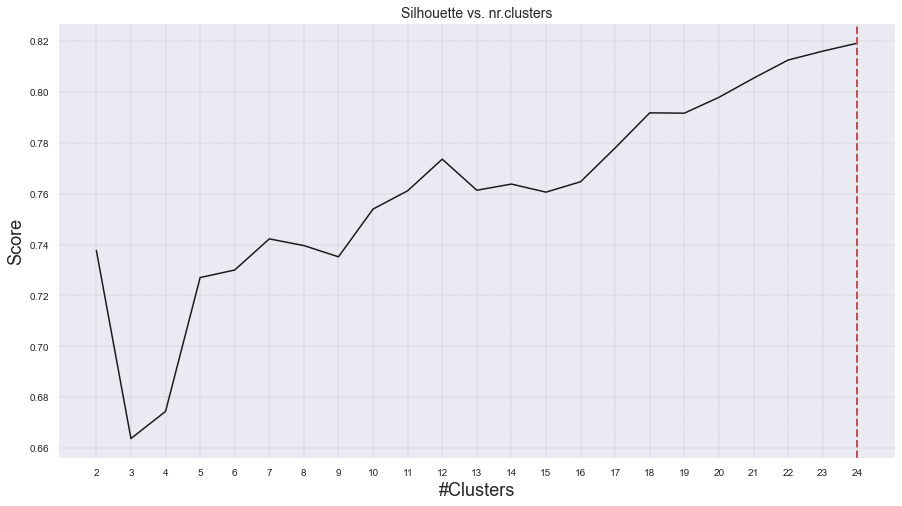

(<Figure size 1080x576 with 1 Axes>,
 <AxesSubplot:title={'center':'Silhouette vs. nr.clusters'}, xlabel='#Clusters', ylabel='Score'>)

In [91]:
ce.plot()

#### Prinicipal Component Analysis

In [92]:
Temp = scaled_data.sample(15000)
pca = PCA(n_components=2)
pca_components = pca.fit_transform(Temp)
pca_components = pd.DataFrame(pca_components,columns=['PC1','PC2'])
pca_components.head()

,PC1,PC2
0,1.13,-0.41
1,-0.47,-0.09
2,1.32,-0.40
3,0.05,-0.80
4,2.19,-0.68


In [93]:
base_spectral = SpectralClustering(random_state=41)

In [94]:
base_spectral.fit(pca_components)

SpectralClustering(random_state=41)

In [95]:
print("Estimated number of clusters:",len(set(base_spectral.labels_)))
print("Clusters:",set(base_spectral.labels_))

Estimated number of clusters: 8
Clusters: {0, 1, 2, 3, 4, 5, 6, 7}


In [96]:
pca_components['Cluster'] = base_spectral.labels_
print("Silhouette Score:",str(np.round(silhouette_score(pca_components,pca_components.Cluster)*100,2)) + '%')

Silhouette Score: 81.0%


<AxesSubplot:xlabel='PC1', ylabel='PC2'>

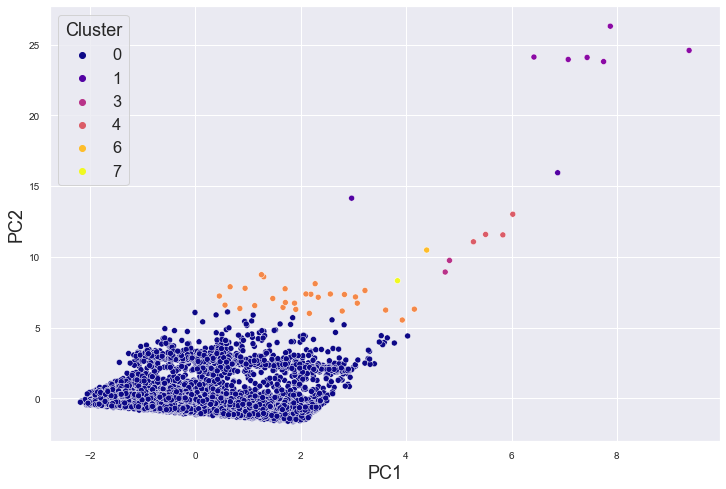

In [97]:
sns.scatterplot(pca_components['PC1'],pca_components['PC2'],hue=pca_components['Cluster'],palette='plasma')

<AxesSubplot:xlabel='Cluster'>

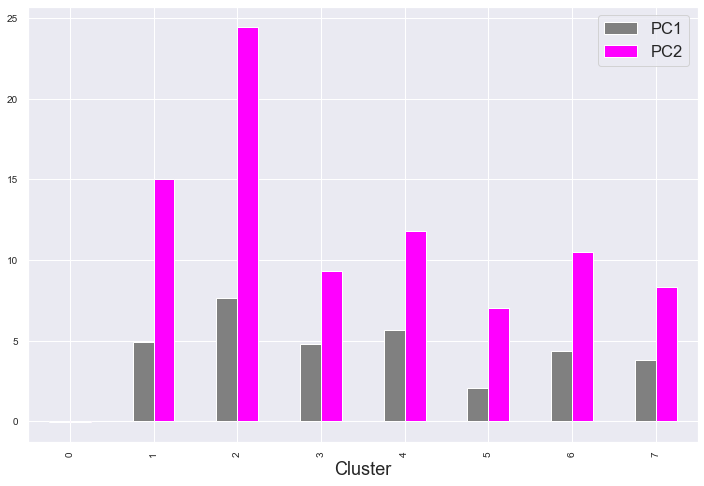

In [98]:
pca_components.groupby('Cluster')[['PC1','PC2']].mean().plot(kind='bar',color=['grey','magenta'])

On Original Feature Space

In [102]:
temp = scaled_data.sample(n=15000)

In [103]:
base_spectral = SpectralClustering(random_state=101)
base_spectral.fit(temp)

SpectralClustering(random_state=101)

In [104]:
print("Estimated number of clusters:",set(base_spectral.labels_))

Estimated number of clusters: {0, 1, 2, 3, 4, 5, 6, 7}


In [105]:
print("Estimated number of noise points:",list(base_spectral.labels_).count(-1))

Estimated number of noise points: 0


In [106]:
print("Silhouette Score:",str(np.round(silhouette_score(temp,base_spectral.labels_)*100,2)) + '%')

Silhouette Score: 64.45%


<AxesSubplot:xlabel='CustAccountBalance', ylabel='TransactionAmount (INR)'>

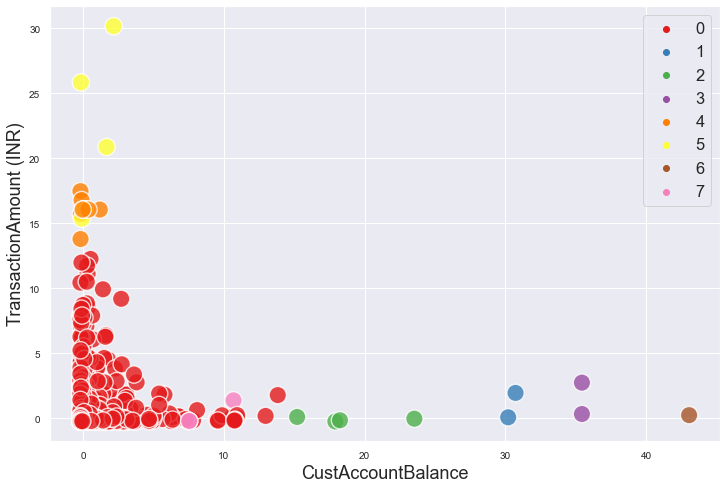

In [107]:
sns.scatterplot(data=temp,x='CustAccountBalance',y='TransactionAmount (INR)',hue=base_spectral.labels_,s=300,alpha=0.8,palette='Set1')